In [9]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from hamp_pred.utils.tools import diffangle
from hamp_pred.utils.meassure import get_ref_crick, crangles

from hamp_pred.external.lbs.sequence import mmseqs2

In [10]:
def plot(df, BINS=26):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    df['rot_mean'].plot.hist(bins=BINS, ax=ax)
    ax.axvline(x=-52, c='r')
    ax.axvline(x=52, c='r')

def balance(df):
    df['freq'] = 1./df.groupby('rot_mean_bin')['rot_mean_bin'].transform('count')
    idx = [df.sample(1, weights = df.freq).iloc[0].name for _ in range(len(df))]
    return idx

## Compute "rot" value (difference between crick angle for N and C helices)

In [11]:
data_df = pd.read_pickle('../data/input/af2_true_full.p') 
data_aer2_df = pd.read_pickle('../data/input/af2_aer2.p')
data_df = pd.concat([data_df, data_aer2_df])

# assymetry is calculated as difference between Crickangle for N and C helices
# those 11 values (length of all common fragments in HAMP) is futher predicted
data_df['rot'] = diffangle(data_df.n_crick_mut, data_df.c_crick_mut)
data_df['rot_mean'] = data_df['rot'].apply(np.mean)
data_df['rot_std'] = data_df['rot'].apply(np.std)

len(data_df)

5342

## Delete samples with "rot" out of range 

In [12]:
def check_crick(row, MAXROT=26):
    return (np.abs(diffangle(row.n_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) and \
           (np.abs(diffangle(row.c_crick_mut[:2].mean(), crangles['a'])) <= MAXROT) 

data_df = data_df[data_df.apply(check_crick, axis=1)]
len(data_df)

4821

In [13]:
data_df = data_df[data_df.rot_std <= 10]
data_df = data_df[data_df.rot_mean.abs() <= 52]
len(data_df)

4305

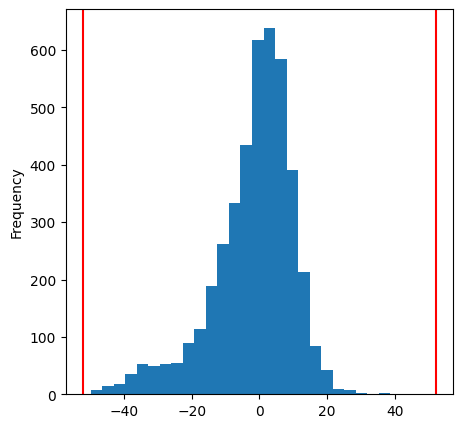

In [14]:
plot(data_df)

## train/val split with class balance

In [15]:
MAX_VAL_FRAC = 0.3 # fraction of val in the whole set
MAX_IDENT = 0.3 # max seq ident between train and validation 

In [18]:
data_df['sequence'] = data_df['n_seq'] + data_df['c_seq'] # for mmseqs2 clustering
c = mmseqs2.MMSeqsClusterer()
data_df = c.cluster(data_df, min_identity=MAX_IDENT)#, coverage=0.7)

In [17]:
def calc_balance(class_name, BINS=26, norm=True):
    tmp = pd.cut(data_df[data_df['class']==class_name].rot_mean, bins=BINS, labels=False, retbins=False)#.value_counts().sort_index()
    res_vec = np.zeros(BINS)
    
    for g_idx, g in tmp.groupby(tmp):
        res_vec[g_idx] = len(g)

    if norm:
        res_vec = res_vec / res_vec.sum()
        
    return res_vec


In [ ]:
final_dist = 1

while final_dist > 0.05:

    data_df['class'] = 'train'
    clusters = data_df.clust_id.unique().tolist()
    prev_dist = 1
    moved=0

    while True:
        # biggest first
        #probability_distribution = 
        cl_move = np.random.choice(clusters)

        data_df.loc[
            data_df.clust_id == cl_move,
            'class'
        ] = 'val'

        train_dist = calc_balance('train')
        val_dist = calc_balance('val')

        dist = np.linalg.norm(train_dist-val_dist)

        if dist < prev_dist:
            # accept cluster move
            clusters.remove(cl_move)
            moved+=1
        else:
            # revert cluster move
            data_df.loc[
                data_df.clust_id == cl_move,
                'class'
            ] = 'train'        

        val_frac = (data_df['class'] == 'val').sum() / len(data_df)

        if val_frac >= MAX_VAL_FRAC: 
            final_dist = dist
            print(final_dist.round(2), moved)
            break

In [ ]:
train_dist = calc_balance('train', norm=False)
val_dist = calc_balance('val', norm=False)

plt.plot(train_dist, label='train')
plt.plot(val_dist, label='val')
plt.legend()

## class balance

In [ ]:
BINS=26

data_df['rot_mean_bin'] = pd.cut(data_df.rot_mean, bins=BINS, labels=False)

data_df_val = data_df[data_df['class'] == 'val'].copy()
data_df_train = data_df[data_df['class'] == 'train'].copy()

In [ ]:
idx_val = balance(data_df_val)
plot(data_df_val.loc[idx_val])

In [ ]:
idx_train = balance(data_df_train)
plot(data_df_train.loc[idx_train])

## Save data

In [ ]:
pd.concat([
    data_df_val.loc[idx_val], 
    data_df_train.loc[idx_train]
]).to_pickle('../data/input/af2_true_full.balance.features.p')